# Imports

In [142]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from openeye import oechem, oedepict
from collections import defaultdict
import random
import pandas as pd
import numpy as np
import tqdm
from harbor.plotting.ligands import plot_aligned_ligands

## Data Loading

In [223]:
mypath = Path("../data/combined_2d.sdf")
mols = Chem.SDMolSupplier(str(mypath))

# save smiles

In [225]:
from asapdiscovery.data.schema.ligand import Ligand
from asapdiscovery.data.readers.molfile import MolFileFactory

In [227]:
mff = MolFileFactory(filename="../data/combined_2d.sdf")

In [228]:
ligs = mff.load()

In [229]:
ligs

[Ligand(compound_name='EDG-MED-5d232de5-6', ids=None, provenance=LigandProvenance(isomeric_smiles='CN1CC[C@H](c2c1ccc(c2)Cl)C(=O)Nc3cncc4c3cccc4', inchi='InChI=1S/C20H18ClN3O/c1-24-9-8-16(17-10-14(21)6-7-19(17)24)20(25)23-18-12-22-11-13-4-2-3-5-15(13)18/h2-7,10-12,16H,8-9H2,1H3,(H,23,25)/t16-/m1/s1', inchi_key='NIZLDWOVHDTVKM-MRXNPFEDSA-N', fixed_inchi='InChI=1/C20H18ClN3O/c1-24-9-8-16(17-10-14(21)6-7-19(17)24)20(25)23-18-12-22-11-13-4-2-3-5-15(13)18/h2-7,10-12,16H,8-9H2,1H3,(H,23,25)/t16-/m1/s1/f/h23H', fixed_inchikey='NIZLDWOVHDTVKM-ZJHKTUGWNA-N'), experimental_data=None, expansion_tag=None, charge_provenance=None, tags={}, conf_tags={}, data_format=<DataStorageType.sdf: 'sdf'>),
 Ligand(compound_name='MAT-POS-f2460aef-1', ids=None, provenance=LigandProvenance(isomeric_smiles='CC(C)(C)c1ccc(cc1)N([C@H](c2cccnc2)C(=O)NCCc3cccc(c3)F)C(=O)c4ccco4', inchi='InChI=1S/C30H30FN3O3/c1-30(2,3)23-11-13-25(14-12-23)34(29(36)26-10-6-18-37-26)27(22-8-5-16-32-20-22)28(35)33-17-15-21-7-4-9-24(31)19-

# Function Definitions

from https://github.com/PatWalters/practical_cheminformatics_posts/blob/main/solubility/helper.py

In [184]:
def generate_scaffold(mol, include_chirality=True):
    """
    Compute the Bemis-Murcko scaffold for a SMILES string.
    Implementation copied from https://github.com/chemprop/chemprop.

    :param mol: A smiles string or an RDKit molecule.
    :param include_chirality: Whether to include chirality.
    :return:
    """
    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)

    return scaffold

def scaffold_to_smiles(mols, use_indices):
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.
    Implementation copied from https://github.com/chemprop/chemprop.

    :param mols: A list of smiles strings or RDKit molecules.
    :param use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in enumerate(mols):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)

    return scaffolds

def scaffold_split(data,
                   sizes = (0.8, 0.2),
                   balanced = True,
                   seed = 0):
    """
    Split a dataset by scaffold so that no molecules sharing a scaffold are in the same split.
    Implementation copied from https://github.com/chemprop/chemprop.

    :param data: List of smiles strings
    :param sizes: A length-2 tuple with the proportions of data in the
    train  and test sets.
    :param balanced: Try to balance sizes of scaffolds in each set, rather than just putting smallest in test set.
    :param seed: Seed for shuffling when doing balanced splitting.
    :return: A tuple containing the train, validation, and test splits of the data.
    """
    assert sum(sizes) == 1

    # Split
    train_size, test_size = sizes[0] * len(data), sizes[1] * len(data)
    train, test = [], []
    train_scaffold_count, test_scaffold_count = 0, 0

    # Map from scaffold to index in the data
    scaffold_to_indices = scaffold_to_smiles(data, use_indices=True)

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets
        index_sets = sorted(list(scaffold_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train) + len(index_set) <= train_size:
            train += index_set
            train_scaffold_count += 1
        else:
            test += index_set
            test_scaffold_count += 1

    #print(f'Total scaffolds = {len(scaffold_to_indices):,} | '
    #                 f'train scaffolds = {train_scaffold_count:,} | '
    #                 f'test scaffolds = {test_scaffold_count:,}')

    # Map from indices to data
    
    #train = [data[i] for i in train]
    #test = [data[i] for i in test]
    #print(train)
    #print(test)
    return train, test

In [185]:
def get_murcko_scaffold_match(scaffold: oechem.OEMol, fitmol: oechem.OEMol):
    # Get Match
    oechem.OESuppressHydrogens(scaffold)
    oechem.OESuppressHydrogens(fitmol)
    scaffold_smiles = oechem.OEMolToSmiles(scaffold)
    ss = oechem.OESubSearch(scaffold_smiles)
    oechem.OEPrepareSearch(scaffold, ss, True)
    if ss.SingleMatch(fitmol):
        pattern_match = list(ss.Match(fitmol))[0]
        found = True
    else:
        found = False
        pattern_match = None
    return found, pattern_match

In [186]:
scaffolds = scaffold_to_smiles(mols, use_indices=False)

In [187]:
scaffold_numbers = [{"scaffold": smiles, "count": len(mols)} for smiles, mols in scaffolds.items()]

In [188]:
df = pd.DataFrame.from_records(scaffold_numbers)

In [189]:
df.sort_values("count", ascending=False)

,scaffold,count
5,O=C(Cc1ccccc1)Nc1cncc2ccccc12,37
10,O=C(Nc1cncc2ccccc12)C1CCOc2ccccc21,25
15,O=C(Nc1cncc2ccccc12)C1CNCc2ccccc21,11
31,O=C(Nc1cncc2ccccc12)C1C[NH2+]Cc2ccccc21,10
34,O=C1NCC(C(=O)Nc2cncc3ccccc23)c2ccccc21,8
...,...,...
36,O=C1N(c2cncc3ccccc23)CCCC12CCOc1ccccc12,1
33,O=C(c1cncc2ccccc12)N1CCN(c2ccccc2)C(=O)C1,1
32,O=C(Nc1cncc2ccccc12)C1(C[NH2+]Cc2cc[nH]n2)CCOc...,1
30,O=C(CC1(C(=O)Nc2cncc3ccccc23)CCOc2ccccc21)N1CC...,1


In [190]:
df.sum()

scaffold    O=C(Nc1cncc2ccccc12)C1CCNc2ccccc21O=C(NCCc1ccc...
count                                                     205
dtype: object

In [191]:
def convert_to_oechem(scaffolds) -> list[dict]:
    return_list = []
    for scaffold, mols in tqdm.tqdm(scaffolds.items()):
        scaffold_oemol = oechem.OEMol()
        oechem.OESmilesToMol(scaffold_oemol, scaffold) 
        mol_list = []
        for mol in mols:
            smiles = Chem.MolToSmiles(mol)
            oemol = oechem.OEMol()
            oechem.OESmilesToMol(oemol, smiles)
            mol_list.append(oemol.__copy__())
        return_list.append({"scaffold": scaffold_oemol.__copy__(), "mols": mol_list})
    return return_list

In [192]:
oechem_list = convert_to_oechem(dict(scaffolds))

100%|██████████| 91/91 [00:00<00:00, 1210.68it/s]


In [193]:
oechem_list

[{'scaffold': <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a7d50> >,
  'mols': [<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d2af510> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d2af6c0> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d389980> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x112c3ad30> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d38a370> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a5bc0> >,
   <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a7000> >]},
 {'scaffold': <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a7d80> >,
  'mols': [<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a7d20> >]},
 {'scaffold': <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a4ea0> >,
  'mols': [<oechem.OEMo

In [194]:
def plot_murcko_scaffold_aligned_ligands(
        filename,
        query_mols: list[oechem.OEMol],
        scaffold: oechem.OEMol,
        max_width: int = 4,
        quantum_width=150,
        quantum_height=200,):
    n_ligands = len(query_mols) + 1
    
    # Prepare image
    cols = min(max_width, n_ligands)
    rows = int(np.ceil(n_ligands / max_width))
    image = oedepict.OEImage(quantum_width * cols, quantum_height * rows)
    grid = oedepict.OEImageGrid(image, rows, cols)
    opts = oedepict.OE2DMolDisplayOptions(
        grid.GetCellWidth(), grid.GetCellHeight(), oedepict.OEScale_AutoScale
    )
    opts.SetTitleLocation(oedepict.OETitleLocation_Bottom)
    opts.SetHydrogenStyle(oedepict.OEHydrogenStyle_Hidden)

    oedepict.OEPrepareDepiction(scaffold)
    
    # Get Scale
    minscale = float("inf")
    for mol in query_mols:
        oedepict.OEPrepareDepiction(mol)
        minscale = min(minscale, oedepict.OEGetMoleculeScale(mol, opts))
    opts.SetScale(minscale)
    
    print(f"minscale: {minscale}")
    
    # Draw Reference
    refdisp = oedepict.OE2DMolDisplay(scaffold, opts)
    refcell = grid.GetCell(1, 1)
    oedepict.OERenderMolecule(refcell, refdisp)
    
    for i, fitmol in enumerate(query_mols):
        
        # Get Match
        found, pattern_match = get_murcko_scaffold_match(scaffold, fitmol)
        
        col = (i + 1) % max_width + 1
        row = int(np.ceil((2 + i) / max_width))
        print(f"{rows}: {row}; {cols}: {col}")
        
        oedepict.OEPrepareDepiction(fitmol)
        
        if found:
            align_result = oedepict.OEPrepareAlignedDepiction(fitmol, scaffold, pattern_match)
        else:
            align_result = oedepict.OEPrepareDepiction(fitmol)

        fitdisp = oedepict.OE2DMolDisplay(fitmol, opts)
        
        
        fitabset = oechem.OEAtomBondSet(
            pattern_match.GetTargetAtoms(), pattern_match.GetTargetBonds()
        )
        oedepict.OEAddHighlighting(
            fitdisp,
            oechem.OEBlueTint,
            oedepict.OEHighlightStyle_BallAndStick,
            fitabset,
        )

        fitcell = grid.GetCell(row, col)
        oedepict.OERenderMolecule(fitcell, fitdisp)
    oedepict.OEWriteImage(filename, image)

In [195]:
# for i,scaffold in tqdm.tqdm(enumerate(oechem_list)):
#     plot_murcko_scaffold_aligned_ligands(filename=f"scaffold_{i}.png",
#                          query_mols=scaffold['mols'],
#                          scaffold=scaffold['scaffold'],
#                                              quantum_width=400,
#                                              quantum_height=400
#                          )

In [196]:
# i = 1
# plot_murcko_scaffold_aligned_ligands(filename=f"scaffold_{i}.png",
#                          query_mols=oechem_list[i]['mols'],
#                          scaffold=oechem_list[i]['scaffold'],
#                                              quantum_width=400,
#                                              quantum_height=400
#                          )

In [197]:
query_mols = oechem_list[1]['mols']
scaffold = oechem_list[1]['scaffold']
max_width = 4
quantum_width=150
quantum_height=200
filename = "scaffold_1.png"

In [198]:
n_ligands = len(query_mols) + 1
    
# Prepare image
cols = min(max_width, n_ligands)
rows = int(np.ceil(n_ligands / max_width))
image = oedepict.OEImage(quantum_width * cols, quantum_height * rows)
grid = oedepict.OEImageGrid(image, rows, cols)
opts = oedepict.OE2DMolDisplayOptions(
    grid.GetCellWidth(), grid.GetCellHeight(), oedepict.OEScale_AutoScale
)
opts.SetTitleLocation(oedepict.OETitleLocation_Bottom)
opts.SetHydrogenStyle(oedepict.OEHydrogenStyle_Hidden)

oedepict.OEPrepareDepiction(scaffold)

True

In [199]:
# Get Scale
minscale = float("inf")
for mol in query_mols:
    oedepict.OEPrepareDepiction(mol)
    minscale = min(minscale, oedepict.OEGetMoleculeScale(mol, opts))
opts.SetScale(minscale)

print(f"minscale: {minscale}")

# Draw Reference
refdisp = oedepict.OE2DMolDisplay(scaffold, opts)
refcell = grid.GetCell(1, 1)
oedepict.OERenderMolecule(refcell, refdisp)

minscale: 16.165478363426676


True

In [200]:
fitmol = query_mols[0]
i = 0

In [201]:
# Get Match
found, pattern_match = get_murcko_scaffold_match(scaffold, fitmol)

col = (i + 1) % max_width + 1
row = int(np.ceil((2 + i) / max_width))
print(f"{rows}: {row}; {cols}: {col}")

1: 1; 2: 2


In [202]:
oedepict.OEPrepareDepiction(fitmol)

True

In [203]:
found

True

In [204]:
pattern_match

<oechem.OEMatchBase; proxy of <Swig Object of type 'OEChem::OEMatchBase *' at 0x15d5a7270> >

In [205]:
scaffold

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x15d5a7d80> >

In [206]:
# oedepict.OEPrepareAlignedDepiction(fitmol, scaffold, pattern_match)

In [207]:
# oedepict.OEPrepareAlignedDepiction(fitmol, scaffold, pattern_match)

In [208]:
# if found:
#     align_result = oedepict.OEPrepareAlignedDepiction(fitmol, scaffold, pattern_match)
# else:
#     align_result = oedepict.OEPrepareDepiction(fitmol)
# 
# fitdisp = oedepict.OE2DMolDisplay(fitmol, opts)

In [209]:
# fitabset = oechem.OEAtomBondSet(
#     pattern_match.GetTargetAtoms(), pattern_match.GetTargetBonds()
# )
# oedepict.OEAddHighlighting(
#     fitdisp,
#     oechem.OEBlueTint,
#     oedepict.OEHighlightStyle_BallAndStick,
#     fitabset,
# )
# 
# fitcell = grid.GetCell(row, col)
# oedepict.OERenderMolecule(fitcell, fitdisp)
# oedepict.OEWriteImage(filename, image)

In [210]:
dict(scaffolds)

{'O=C(Nc1cncc2ccccc12)C1CCNc2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15e111150>,
  <rdkit.Chem.rdchem.Mol at 0x15e1acf20>},
 'O=C(NCCc1ccccc1)C(c1cccnc1)N(C(=O)c1ccco1)c1ccccc1': {<rdkit.Chem.rdchem.Mol at 0x15e1425e0>},
 'O=C(Nc1cncc2ccccc12)C1COc2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15e142650>},
 'O=C1N(c2cncc3ccccc23)CCC12CN(S(=O)(=O)CC1CC1)Cc1ccccc12': {<rdkit.Chem.rdchem.Mol at 0x15e142730>,
  <rdkit.Chem.rdchem.Mol at 0x15e19f370>},
 'O=C(Nc1cccnc1)C1CCOc2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15db8c270>,
  <rdkit.Chem.rdchem.Mol at 0x15e110820>},
 'O=C(Cc1ccccc1)Nc1cncc2ccccc12': {<rdkit.Chem.rdchem.Mol at 0x15e1102e0>,
  <rdkit.Chem.rdchem.Mol at 0x15e19fca0>},
 'O=C(Nc1cncc2ccccc12)C1CNc2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15e142880>},
 'O=C(Nc1cncc2ccccc12)C1CN(S(=O)(=O)CC2CCC2)Cc2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15e142960>},
 'O=C(Nc1cncc2ccccc12)C1CN(S(=O)(=O)CC2CC2)C(=O)c2ccccc21': {<rdkit.Chem.rdchem.Mol at 0x15e1429d0>},
 'O=C1N(c2cncc3ccccc23)CCC12CCOc1ccccc12

In [211]:
oechem_list = sorted(oechem_list, key=lambda x: len(x["mols"]), reverse=True)

In [212]:
rmol = Chem.MolFromSmiles(oechem.OEMolToSmiles(oechem_list[2]['scaffold']))
r2mol = Chem.MolFromSmiles(oechem.OEMolToSmiles(oechem_list[3]['scaffold']))

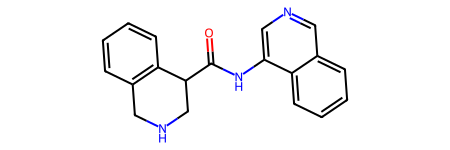

In [213]:
Chem.RemoveHs(rmol)

In [214]:
Chem.RemoveHs?

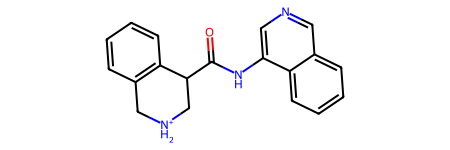

In [215]:
Chem.RemoveHs(r2mol)

In [216]:
scaffold_list = [{"scaffold": Chem.MolFromSmiles(scaffold), "mols": mols} for scaffold, mols in dict(scaffolds).items()]

In [217]:
scaffold_list = sorted(scaffold_list, key=lambda x: len(x["mols"]), reverse=True)

In [218]:
from rdkit.Chem import rdMolAlign, rdDepictor

In [219]:
def align_to_scaffold(scaffold: Chem.Mol, mols: list[Chem.Mol]):
    rdDepictor.Compute2DCoords(scaffold)
    template_match = scaffold.GetSubstructMatch(scaffold)
    for mol in mols:
        rdDepictor.Compute2DCoords(mol)
        query_match = mol.GetSubstructMatch(scaffold)
        rdMolAlign.AlignMol(mol, scaffold, atomMap=list(zip(query_match, template_match)))
    return scaffold, mols

In [220]:
scaffold = scaffold_list[0]["scaffold"]
mols = scaffold_list[0]["mols"]
# scaffold, mols = align_to_scaffold(scaffold, mols)

In [221]:
from rdkit.Chem import Draw
highlight = [mol.GetSubstructMatch(scaffold) for mol in mols]
dopts = Draw.rdMolDraw2D.MolDrawOptions()
dopts.setHighlightColour((68/256, 178/256, 212/256))
dopts.highlightBondWidthMultiplier = 16
image = Draw.MolsToGridImage(mols, 
                    legends = [Chem.MolToSmiles(mol) for mol in mols],
                    molsPerRow=6,
                    subImgSize=(250,150),
                    useSVG=True,
                    highlightAtomLists=highlight,
                             drawOptions=dopts)

In [222]:
with open('output.svg', 'w') as f:
    f.write(image.data)